In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import os
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from wmt_inert_tracer.swmt import swmt
from wmt_inert_tracer.preprocessing import preprocessing
from wmt_inert_tracer.compute import lbin_define

In [4]:
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import hovmoeller, cartopy_map_so
from compute import horizontal_mean

In [5]:
outdir='/work/jet/data/interim/'

# Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/' # Odiv-183, Odiv-170

subdir = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt3' # Odiv-207
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt2' # Odiv-206
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200
#subdir = 'CM4_piControl_c192_OM4p125_v6' # Odiv-191
#subdir = 'CM4_piControl_c192_OM4p125_v5' # Odiv-184
#subdir = 'CM4_piControl_c192_OM4p125_v5_proto1' # Odiv-183
#subdir = 'CM4_piControl_c192_OM4p25' # Odiv-170

platfrom = 'gfdl.ncrc4-intel18-prod-openmp'

In [6]:
ddict = {pp:{} for pp in ['ice','ocean_monthly']}
for pp in ddict:
    full_path = os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/ts/monthly/5yr/'
    print(full_path)
    #'MIB','RAIN','simass','sithick','sivol','sisnmass'
    var = ['siconc'] if pp=='ice' else ['tos','sos']#,'wfo','prlq','prsn','ficeberg']
    for v in var:
        print(v)
        ddict[pp][v] = xr.open_mfdataset(full_path+'/'+pp+'.*.'+v+'.nc',use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])

/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ice/ts/monthly/5yr/
siconc
/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/
tos
sos


In [7]:
vars_ice_ds = xr.merge([ddict['ice'][v] for v in ddict['ice']])

In [8]:
vars_ds = xr.merge([ddict['ocean_monthly'][v] for v in ddict['ocean_monthly']])

In [9]:
vars_ds = xr.merge([vars_ds, vars_ice_ds.rename({'xT':'xh','yT':'yh','xTe':'xq','yTe':'yq'})])

In [10]:
pp = 'ocean_monthly'
grid = xr.open_dataset(os.path.join(rootdir,subdir,platfrom,'pp',pp)+'/'+pp+'.static.nc')

In [11]:
#grid = grid.assign_coords({'xh':vars_ds.xh,'yh':vars_ds.yh,'xq':vars_ds.xq,'yq':vars_ds.yq}) # Odiv-183
#grid = grid.isel(xq=slice(1,None),yq=slice(1,None)) # Odiv-183, Odiv-170

vars_ds = vars_ds.isel(xq=slice(1,None),yq=slice(1,None)) # Odiv-200, Odiv-191, Odiv-184, Odiv-183, Odiv-170
grid = grid.isel(xq=slice(None,-1),yq=slice(None,-1)) # Odiv-200, Odiv-191, Odiv-184

In [12]:
ds = preprocessing(vars_ds, grid, decode_times=False, verbose=False)

In [13]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

0001-01-16 to 0090-12-16


In [14]:
# Subselect Southern Ocean
#north = -30.0
north = -60.0

ds_so = ds.drop_dims('nv').where(ds.lat<north,drop=True)

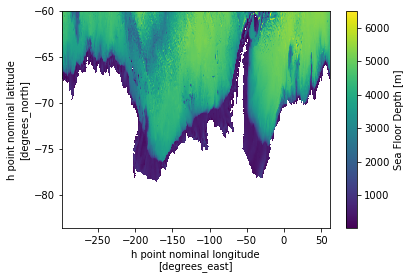

In [15]:
ds_so.deptho.plot()

In [16]:
onshlf = ds_so.where(ds_so.deptho<1000,drop=True)
offshr = ds_so.where(ds_so.deptho>=1000,drop=True)
    
onshlf['time_bnds'] = ds.time_bnds
offshr['time_bnds'] = ds.time_bnds

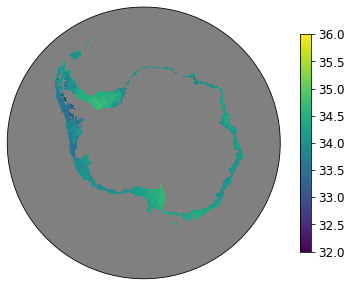

In [17]:
fig, ax = cartopy_map_so(onshlf.isel(time=7),'sos', lat=-55, fsize=[7,5],vrange=[32,36])

### Sea surface salinity over the Antarctic shelf

In [19]:
onshlf = onshlf.sel(time=slice('0061',None))

In [20]:
with ProgressBar():
    sss_so = horizontal_mean(onshlf.sos,onshlf).load()

[########################################] | 100% Completed | 38.0s


In [22]:
sss_so = xr.concat([xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v7_0001to0060_sss_onshlf.nc').sos,sss_so],dim='time')

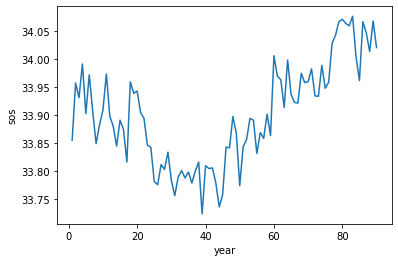

In [23]:
sss_so.groupby('time.year').mean('time').plot()

In [24]:
fname = subdir+'_%sto%s_sss_onshlf.nc'%(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'))
print('Saving to file:', fname)
sss_so.reset_coords(drop=True).to_dataset(name='sos').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v7_0001to0090_sss_onshlf.nc


In [25]:
fname_odiv1 = 'CM4_piControl_0001to0300_sss_onshlf.nc'
#fname_odiv191 = 'CM4_piControl_c192_OM4p125_v6_0001to0040_sss_onshlf.nc'
fname_odiv200 = 'CM4_piControl_c192_OM4p125_v6_alt1_0001to0200_sss_onshlf.nc'
fname_odiv206 = 'CM4_piControl_c192_OM4p125_v6_alt2_0181to0200_sss_onshlf.nc'
fname_odiv207 = 'CM4_piControl_c192_OM4p125_v6_alt3_0181to0200_sss_onshlf.nc'
fname_odiv209 = 'CM4_piControl_c192_OM4p125_v7_0001to0090_sss_onshlf.nc'

ddict = {s:{} for s in ['Odiv-1','Odiv-200','Odiv-206','Odiv-207','Odiv-209']} #'Odiv-191'
ddict['Odiv-1'] = xr.open_dataset(outdir+fname_odiv1).sos
ddict['Odiv-200'] = xr.open_dataset(outdir+fname_odiv200).sos
#ddict['Odiv-191'] = xr.open_dataset(outdir+fname_odiv191).sos
ddict['Odiv-206'] = xr.open_dataset(outdir+fname_odiv206).sos
ddict['Odiv-207'] = xr.open_dataset(outdir+fname_odiv207).sos
ddict['Odiv-209'] = xr.open_dataset(outdir+fname_odiv209).sos

In [26]:
sss_so_jra = xr.open_dataset(outdir+'OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3_1958to1962_sss_onshlf.nc').sos
sss_so_core = xr.open_dataset(outdir+'OM4p25_CORE_1968to1987_sss_onshlf.nc').sos

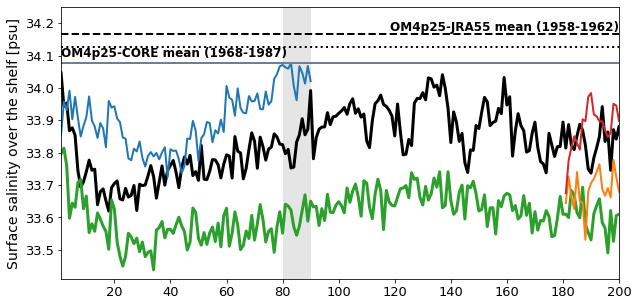

In [31]:
cstr = ['k','tab:green','tab:orange','tab:red','tab:blue']

fig, ax = plt.subplots(figsize=(10,5))

for i, s in enumerate(ddict):
    
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,lw=3 if s in ['Odiv-1','Odiv-200'] else 2,c=cstr[i],_labels=False,label=s)
    
ax.axhline(y=sss_so_jra.mean('time'), xmin=0, xmax=1, c = 'k', lw=2.0, ls='--')
ax.axhline(y=sss_so_core.mean('time'), xmin=0, xmax=1, c = 'k', lw=2.0, ls=':')
ax.axhline(y=34.076182988906744, xmin=0, xmax=1, c = 'slategrey', lw=2.0, ls='-')

#ax.axvline(x=80, c = 'k', ls='-', lw=1, alpha=0.5)
#ax.axvline(x=90, c = 'k', ls='-', lw=1, alpha=0.5)
ylimit = ax.get_ylim()
ax.fill([80,90,90,80],[ylimit[0],ylimit[0],ylimit[1]+0.2,ylimit[1]+0.2],'grey', alpha=0.2, edgecolor='None')


ax.set_xlim([1, 200])
ax.set_xticks(np.arange(20,220,20), minor=False)
#ax.legend(frameon=True, fancybox=True,loc='upper left', ncol=3, fontsize=12)
ax.set_ylim([33.41, 34.25])
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('Surface salinity over the shelf [psu]',fontsize=14)
ax.text(200, sss_so_jra.mean('time'), 'OM4p25-JRA55 mean (1958-1962)', ha='right', va='bottom', fontsize=12, fontweight='bold')
ax.text(1, sss_so_core.mean('time'), 'OM4p25-CORE mean (1968-1987)', ha='left', va='top', fontsize=12, fontweight='bold')

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

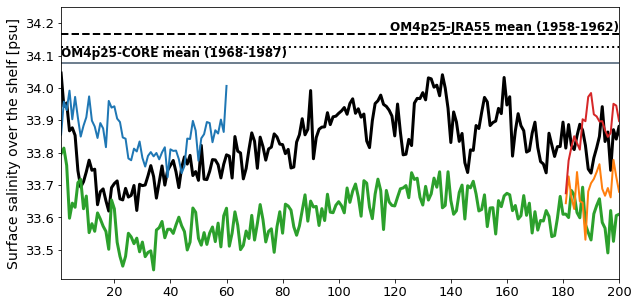

### Freshwater fluxes over the Antarctic shelf

In [ ]:
yr_st,yr_ed = '0181','0190'

In [23]:
def horizontal_sum(da, metrics):
    num = (da * metrics['areacello'] * metrics['wet']).sum(dim=['x', 'y'])
    return num

In [24]:
with ProgressBar():
    wfo_onshlf = horizontal_sum(onshlf.wfo,onshlf).load()

[########################################] | 100% Completed |  8min 23.9s


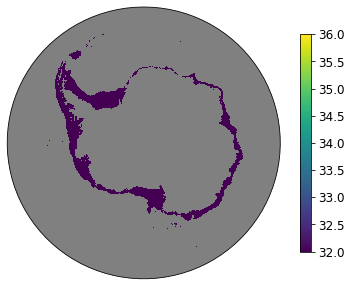

In [28]:
fig, ax = cartopy_map_so(onshlf.isel(time=7),'wfo', lat=-55, fsize=[7,5],vrange=[32,36])

In [29]:
with ProgressBar():
    wfo_onshlf_mean = horizontal_mean(onshlf.wfo,onshlf).load()

[########################################] | 100% Completed |  4min 41.4s


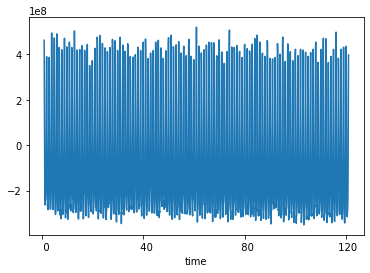

In [25]:
wfo_onshlf.plot()

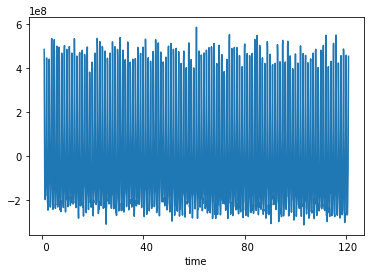

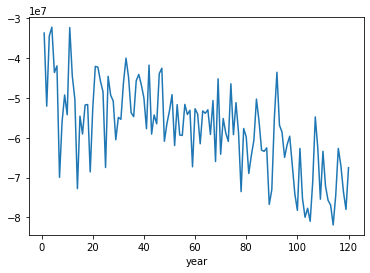

In [27]:
wfo_onshlf.groupby('time.year').mean('time').plot()

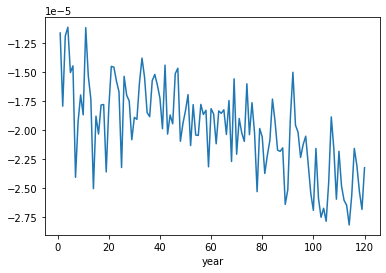

In [30]:
wfo_onshlf_mean.groupby('time.year').mean('time').plot()

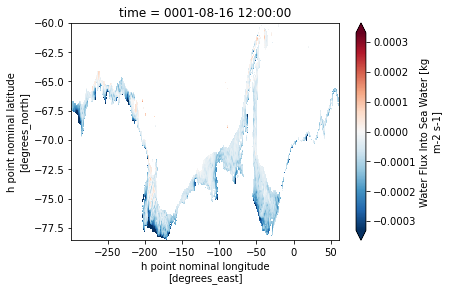

In [26]:
onshlf.isel(time=7).wfo.plot(robust=True)

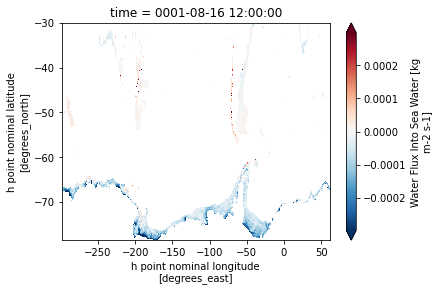

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
for v in G.keys():
    if v != 'total':
        ax.plot(G[lstr], G[v].mean('time')*1e-6, lw=2, linestyle='-', label=v)
    else:
        ax.plot(G[lstr], G[v].mean('time')*1e-6, lw=2, linestyle='--', c = 'k', label=v)

ax.legend(loc='center left',bbox_to_anchor=(1, 0.55))
plt.show()

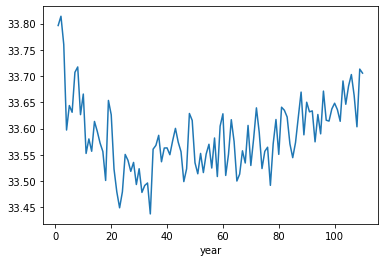

In [50]:
with ProgressBar():
    sst_so = horizontal_mean(onshlf.tos,onshlf).load()

[########################################] | 100% Completed |  2min 28.9s


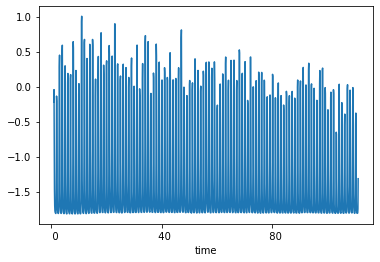

In [51]:
sst_so.plot()

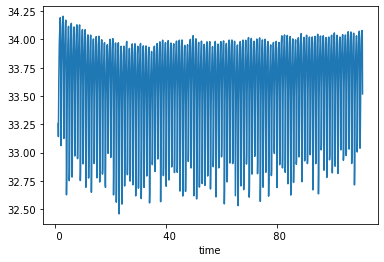

In [47]:
sss_so.plot()

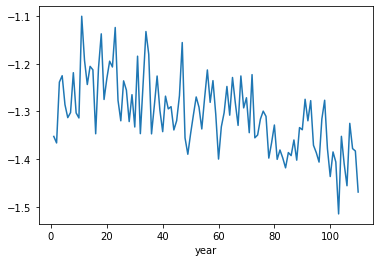

In [52]:
sst_so.groupby('time.year').mean('time').plot()

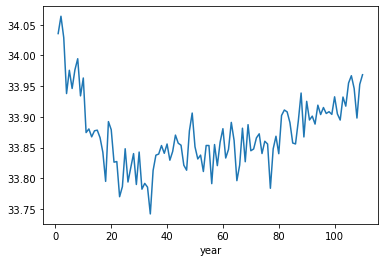

In [49]:
sss_so[(sss_so.time.dt.month>=6) & (sss_so.time.dt.month<9)].groupby('time.year').mean('time').plot()